In [1]:
# imports

# data handling
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# set styles
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.style.use('seaborn-darkgrid')
sns.set_style("darkgrid")

# database connection
from sqlalchemy import create_engine
from config import db_key

import geopy.distance


%matplotlib inline

## Data Loading

In [2]:
# load dataset from raw csv github url.
# pandas read_csv() function can read in data from a url when passed as a string.

cal_housing_url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv"
cal_df = pd.read_csv(cal_housing_url)

# show shape and first ten rows of data
print(cal_df.shape)
cal_df.head(10)

(20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


## EDA (Exploratory Data Analysis)

In [3]:
# check data types
cal_df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [4]:
# we have a majority of numerical variables, get summary statistics
cal_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


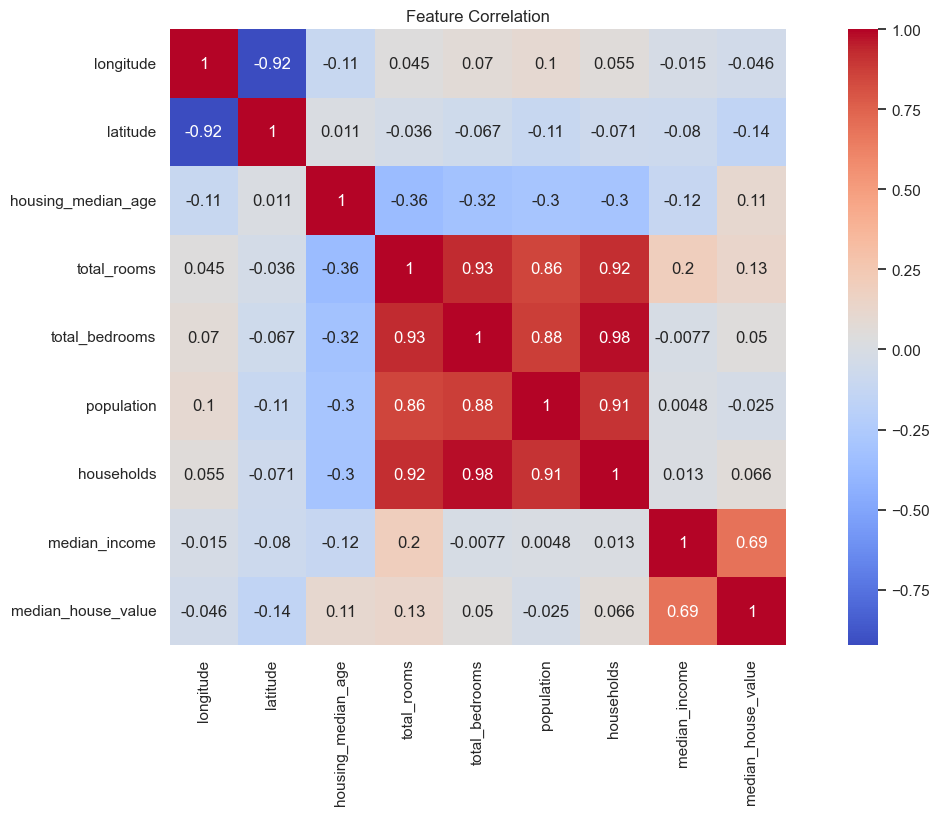

In [5]:
# create correlation heat map
# create correlation matrix
corr = cal_df.corr()

# create heatmap
sns.set(rc={'figure.figsize':(16,8)})
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True).set(title='Feature Correlation')
plt.show()

longitude       latitude              0.924664
households      total_rooms           0.918484
population      households            0.907222
total_bedrooms  population            0.877747
total_rooms     population            0.857126
median_income   median_house_value    0.688075
total_rooms     housing_median_age    0.361262
dtype: float64


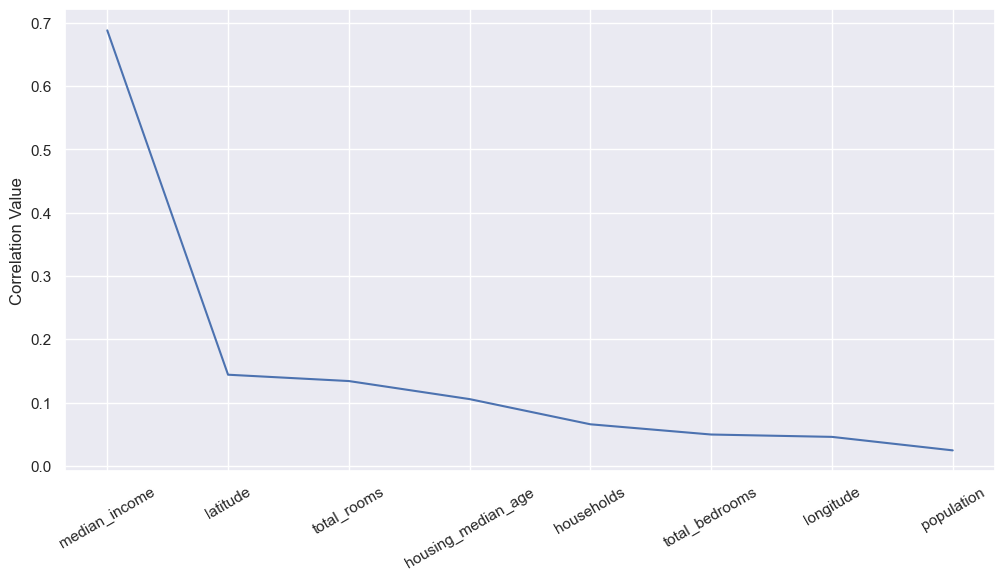

In [6]:
# unstack and sort absolute correlation values to show top correlations
# here we see that the correlation between income and house value is one of the highest correlations in our data
c1 = corr.abs().unstack()
print(c1.sort_values(ascending = False)[14:28:2])

# plot target variables absolute correlation values in descending order
fig, ax = plt.subplots(figsize =(12, 6))
plt.plot(abs(corr)['median_house_value'].sort_values(ascending=False)[1:], label='Correlation to Median House Value')
plt.ylabel('Correlation Value')
plt.xticks(rotation=30)
plt.show()

# Handle Missing Data

In [7]:
# check for missing data
cal_df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

count    20433.000000
mean       537.870553
std        421.385070
min          1.000000
25%        296.000000
50%        435.000000
75%        647.000000
max       6445.000000
Name: total_bedrooms, dtype: float64


<AxesSubplot:ylabel='Frequency'>

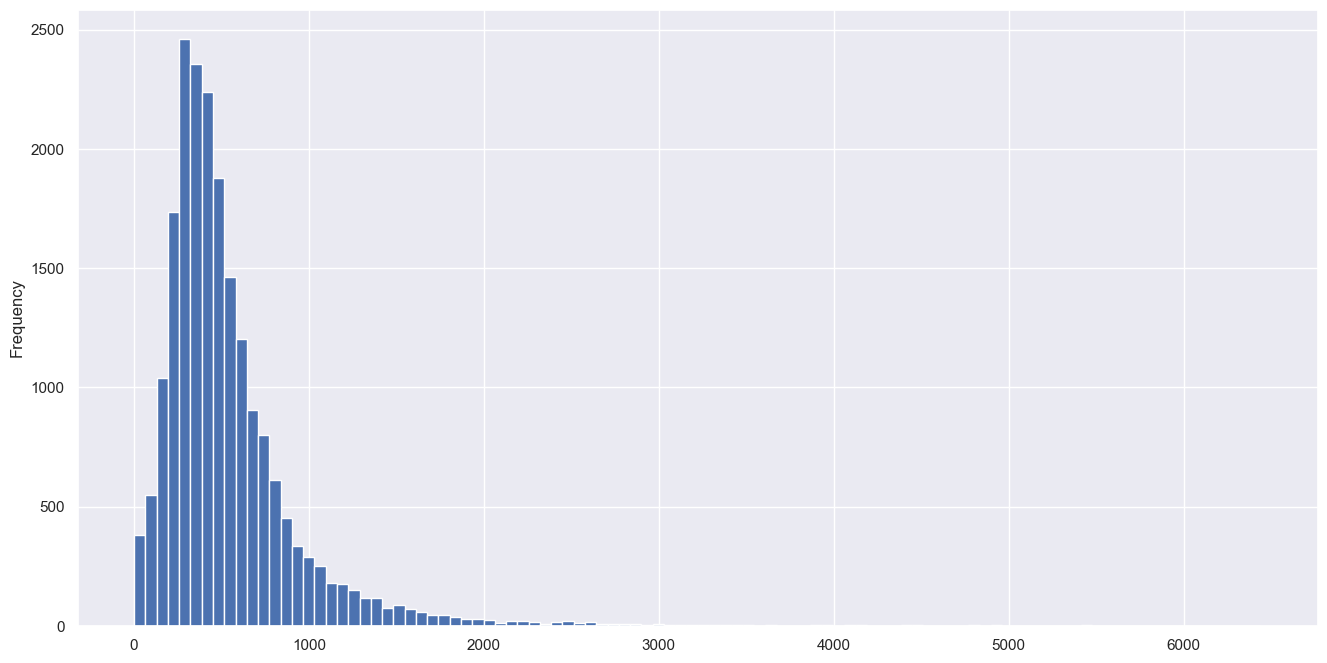

In [8]:
# show hist  and stats for total_bedrooms to assess strategy
print(cal_df.total_bedrooms.describe())
cal_df.total_bedrooms.plot.hist(bins=100)

In [9]:
# decide what to do with 207 missing values in total_bedrooms: drop observations or fill with median
# total_bedrooms is slightly skewed, but has relatively high density near the median, keep values and fill with median

# fill with median using SimpleImputer and median fill strategy
# create imputer instance to get median for each feature
medians = SimpleImputer(strategy='median')
# select numerical columns
num_col = cal_df.drop(['latitude', 'longitude', 'ocean_proximity'], axis=1)
# fit imputer to columns
medians = medians.fit(num_col)
# fill missing values
num_col_filled = medians.transform(num_col)
# replace in original dataframe
cal_df[num_col.columns] = num_col_filled

print("__________Medians___________")
print(medians.statistics_.round())
print(num_col.median())
print("__________Nulls____________")
print(cal_df.isnull().sum())

__________Medians___________
[2.900e+01 2.127e+03 4.350e+02 1.166e+03 4.090e+02 4.000e+00 1.797e+05]
housing_median_age        29.0000
total_rooms             2127.0000
total_bedrooms           435.0000
population              1166.0000
households               409.0000
median_income              3.5348
median_house_value    179700.0000
dtype: float64
__________Nulls____________
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


In [10]:
# check the shape of our data: 20640 observations on 10 features
cal_df.shape

(20640, 10)

# Target Feature Analysis

In [11]:
# our dependent variable is 'median_house_value'
# get statistical description for target variable
cal_df.median_house_value.describe()

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

Observations with greater than $500,000 Median House Value: 965


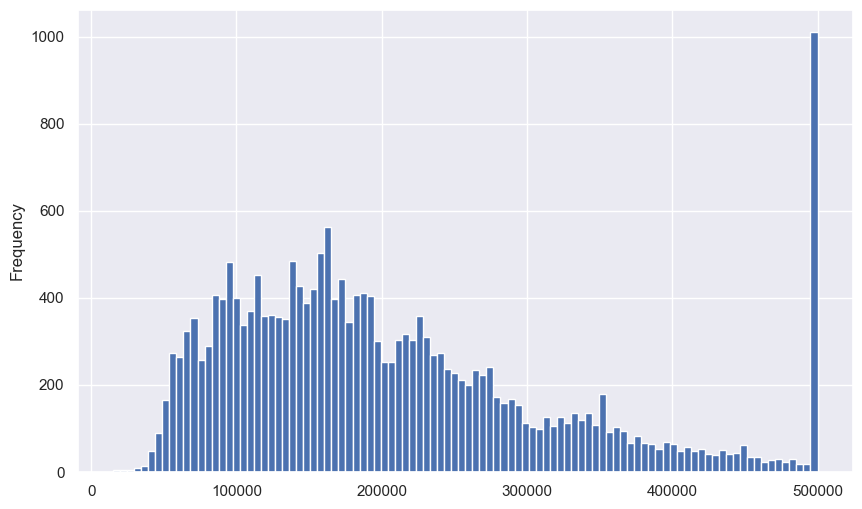

In [12]:
# show dependent variable distribution
# here we see the large number of censored observations (965). These may need to be eliminated as outliers
cap_vals= len(cal_df[cal_df['median_house_value'] > 500000])
print(f'Observations with greater than $500,000 Median House Value: {cap_vals}')
cal_df.median_house_value.plot.hist(bins=100, figsize=(10,6))
plt.show()

C:\Users\kdrni\anaconda3\envs\PythonData\envs\mlenv\lib\site-packages\ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


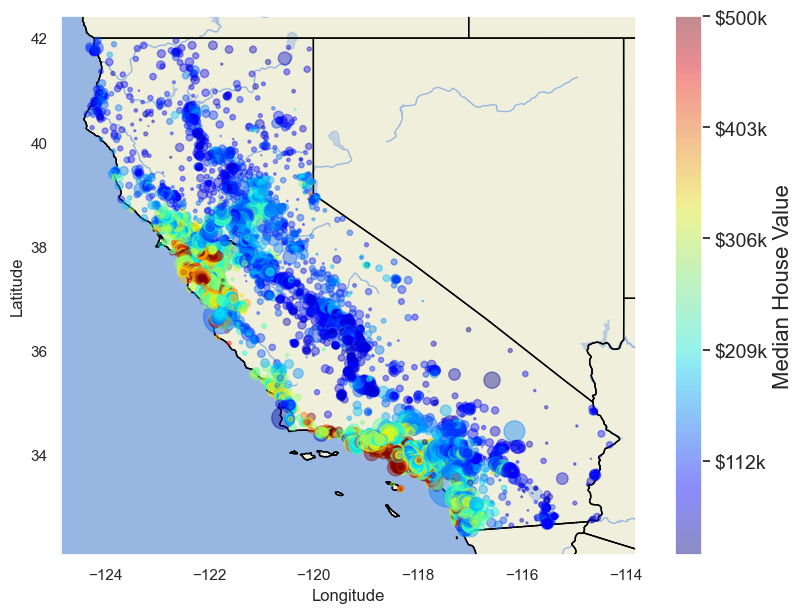

In [13]:
# map observations by coordinates, show median_house_value as size, map by ocean_proximity
# mapping features
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(10,7))

# Creates the map
ca_map = plt.axes(projection=ccrs.PlateCarree())

ca_map.add_feature(cfeature.LAND)
ca_map.add_feature(cfeature.OCEAN)
ca_map.add_feature(cfeature.COASTLINE)
ca_map.add_feature(cfeature.BORDERS, linestyle=':')
ca_map.add_feature(cfeature.LAKES, alpha=0.5)
ca_map.add_feature(cfeature.RIVERS)
ca_map.add_feature(cfeature.STATES.with_scale('10m'))

ca_map.xaxis.set_visible(True)
ca_map.yaxis.set_visible(True)

# Plots the data onto map
plt.scatter(cal_df['longitude'], cal_df['latitude'], alpha=0.4, 
            s=cal_df["population"]/50, label="population",
            c=cal_df['median_house_value'], 
            cmap=plt.get_cmap("jet"), 
            transform=ccrs.PlateCarree())

# Colorbar
prices = cal_df["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 6)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

# Plot labels
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.show()

# ID Column Creation

In [14]:
# create id column from index for database
cal_df['id'] = cal_df.index+1
print(cal_df.dtypes)
cal_df.tail()

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
id                      int64
dtype: object


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,20636
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,20637
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,20638
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,20639
20639,-121.24,39.37,16.0,2785.0,616.0,1387.0,530.0,2.3886,89400.0,INLAND,20640


# Location Feature Analysis

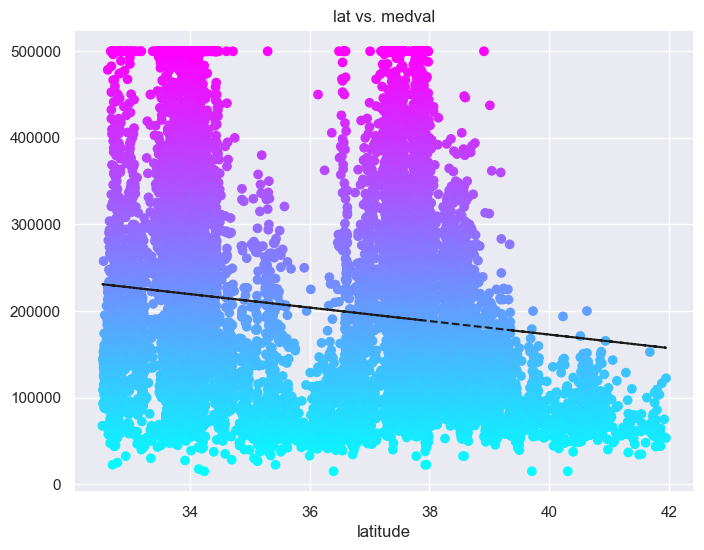

In [15]:
# check correlations of coordinates and dependent variable before removal of location data
# set variables for plotting
x=cal_df.latitude
y=cal_df.median_house_value

plt.subplots(figsize=(8, 6))
# create scatter plot
plt.scatter(x=x, y=y, c=y, cmap='cool')

# fit regression line and plot
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x), "k--")

# update plot labels
plt.title('lat vs. medval')
plt.xlabel('latitude')
plt.show()

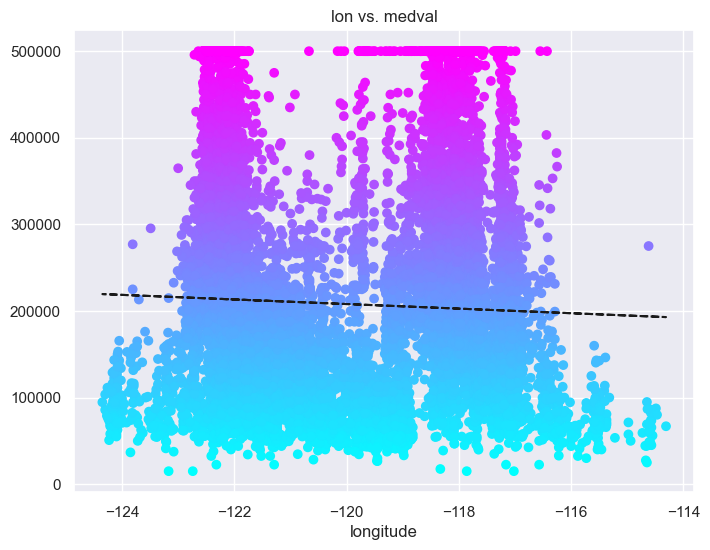

In [16]:
# these plots reveal that high home values tend to be located around 2 areas in both latitude and longitude
# these are likely the locations of major cities, suggest add feature 'distance from major city(Los Angeles, San Francisco)'
# beyond this the coordinates are not highly correlated and can be dropped to locations table
x=cal_df.longitude
y=cal_df.median_house_value

plt.subplots(figsize=(8, 6))
# create scatter plot
plt.scatter(x=x, y=y, c=y, cmap='cool')

# fit regression line and plot
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x), "k--")

# update plot labels
plt.title('lon vs. medval')
plt.xlabel('longitude')
plt.show()

## Create new features distance to major cities. 

In [17]:
# Mapping of home values shows 4 hotspots located near 4 major cities in California
# The distances of each block group from each of these urban centers will be calculated here and shortes will
# be added to the database as a new feature miles_nearest_major_city
# make new features: Distance from nearest major city

# set coordinates for major cities
cities_dict = {'Los_Angeles':(34.0522, -118.2437),
                'San_Francisco':(37.7749, -122.4194),
                'San_Diego':(32.7157, -117.1611),
                'San_Jose':(37.3387, -121.8853)}

# iterate through rows and get shortes distance to major city
distances = []

for index, row in cal_df.iterrows():
    # create list for distances
    dis = []
    # get coordinates of block group
    coord = (row['latitude'], row['longitude'])
    # get distances to each city with geopy
    dis.append(round(geopy.distance.geodesic(cities_dict['Los_Angeles'], coord).miles, 2))
    dis.append(round(geopy.distance.geodesic(cities_dict['San_Francisco'], coord).miles, 2))
    dis.append(round(geopy.distance.geodesic(cities_dict['San_Diego'], coord).miles, 2))
    dis.append(round(geopy.distance.geodesic(cities_dict['San_Jose'], coord).miles, 2))
    # sort values to get shortest distance
    dis.sort()
    # add shortest distance to complete list
    distances.append(dis[0])

# join new feature with original features, keep original dataframe
new_cal_df = cal_df.copy()
new_cal_df['miles_nearest_major_city'] = distances
new_cal_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id,miles_nearest_major_city
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,1,12.64
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,2,12.39
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,3,11.10
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4,10.62
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,5,10.62


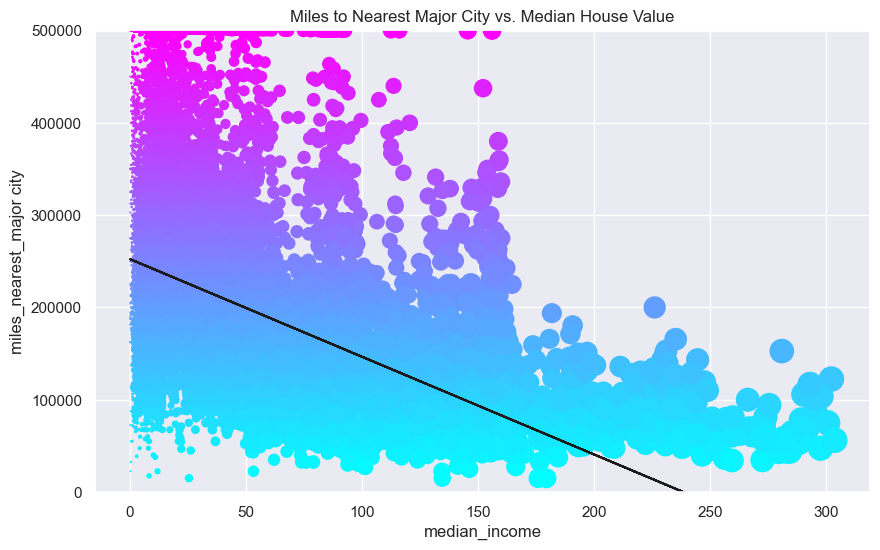

In [18]:
# plot correlation with home value and distance to major city
# here we see a much higher correlation than the coordinates alone.


# set variables for plotting
x=new_cal_df.miles_nearest_major_city
y=new_cal_df.median_house_value

# create scatter plot
plt.subplots(figsize=(10,6))
plt.scatter(x=x, y=y, c=y, cmap='cool', s=x)

# fit regression line and plot
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x), "k--")

# update plot labels
plt.title('Miles to Nearest Major City vs. Median House Value')
plt.xlabel('median_income')
plt.ylabel('miles_nearest_major city')
plt.ylim(0,500500)
plt.show()

In [19]:
# the coordinates were overwhelmingly correlated with themselves, and not so much with anything else. 
# ocean_proximity covers one dimension of these features, distance from major city another
# we are going to seperate the the latitude and longitude from the other features for storage in the database and model training
# seperate data into features and locations tables
cal_locations = new_cal_df[['id', 'longitude', 'latitude']].copy()
cal_features = new_cal_df[['id', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 
                        'households', 'median_income', 'ocean_proximity', 'median_house_value','miles_nearest_major_city']].copy()

print(cal_locations.dtypes)
cal_locations.head()

id             int64
longitude    float64
latitude     float64
dtype: object


,id,longitude,latitude
0,1,-122.23,37.88
1,2,-122.22,37.86
2,3,-122.24,37.85
3,4,-122.25,37.85
4,5,-122.25,37.85


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

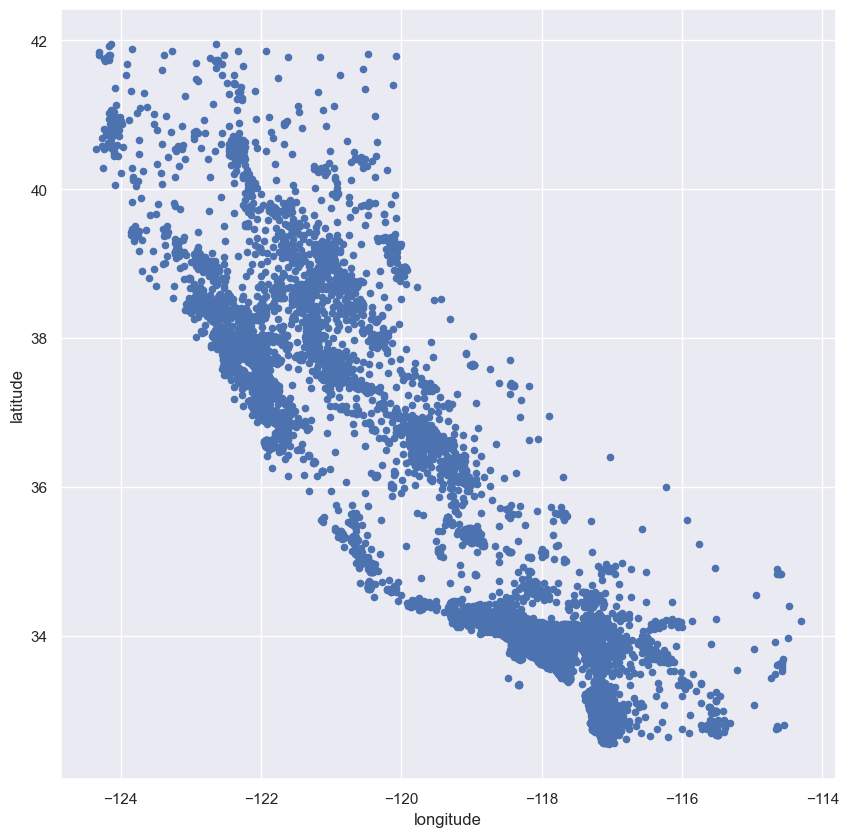

In [20]:
# check locations
cal_locations.plot.scatter(x='longitude', y='latitude',figsize=(10, 10))

## Database Connection & Location Table Database Export

In [21]:
# create database connection using SQLAlchemy
user = "Housing_Database"
password = db_key
host = "housing-database.c6zoxppofyzr.us-east-1.rds.amazonaws.com"
port = '5432'
database = "postgres"

con_string = f'postgresql://{user}:{password}@{host}:{port}/{database}'
engine = create_engine(con_string)


In [22]:
# insert location data into table in database
cal_locations.to_sql('locations', con=engine, index=False, if_exists='replace')
print(engine.execute("SELECT * FROM locations").fetchone())

(1, -122.23, 37.88)


# Ocean Proximity Feature Analysis

In [23]:
# mapping revealed a potential stratification in home values based on proximity to the ocean
# show value counts of categorical variable 'ocean_proximity'
cal_features.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

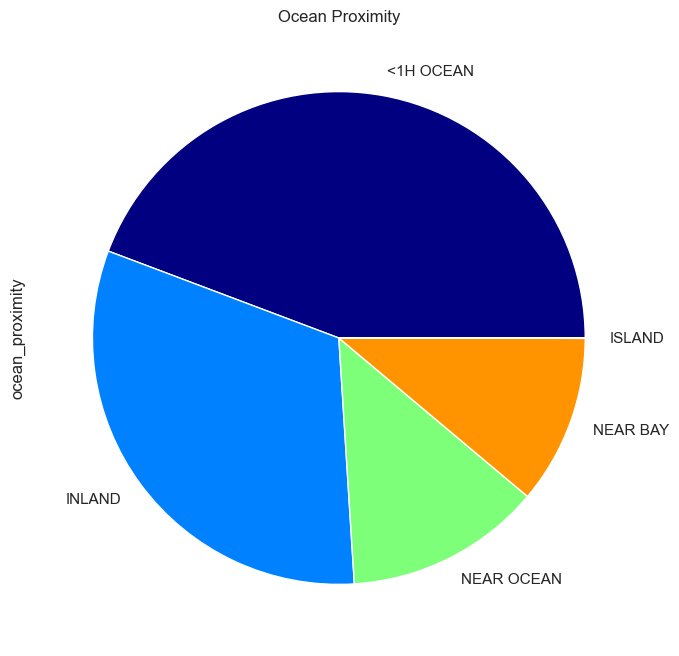

In [24]:
# pie chart to visualize ocean proximity distribution
cal_features.ocean_proximity.value_counts().plot(kind='pie', colormap='jet')
plt.title("Ocean Proximity")
plt.show()

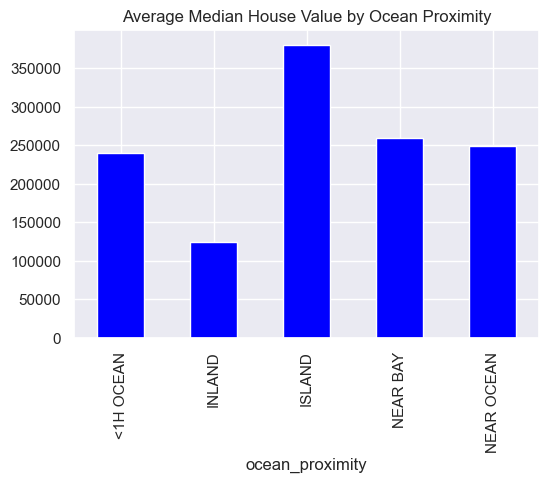

In [25]:
# plot categorical variables average home values
val_by_prox = cal_features.groupby('ocean_proximity')['median_house_value'].mean()
val_by_prox.plot(kind='bar', figsize=(6, 4), color='blue')
plt.title("Average Median House Value by Ocean Proximity")
plt.show()


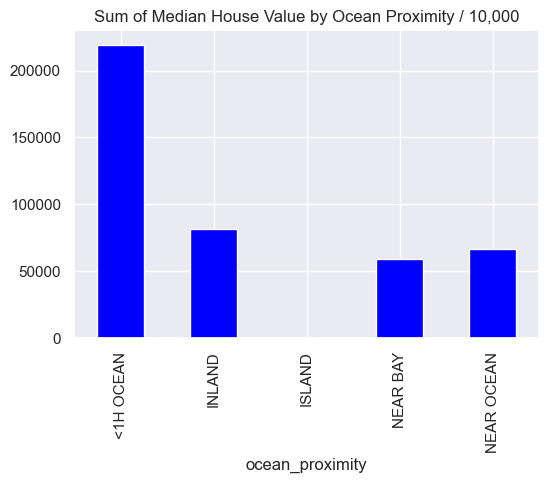

In [26]:
# show sum of median home values by ocean proximity
# this makes sense to some degree. The three lowest values are in the least populated zones. 
# <1h from ocean far outreaches Inland with its greater median house value . 
sum_by_prox = cal_features.groupby('ocean_proximity')['median_house_value'].sum()/10000
sum_by_prox.plot(kind='bar', figsize=(6, 4), color='blue')
plt.title("Sum of Median House Value by Ocean Proximity / 10,000")
plt.show()


# Median Income Feature Analysis

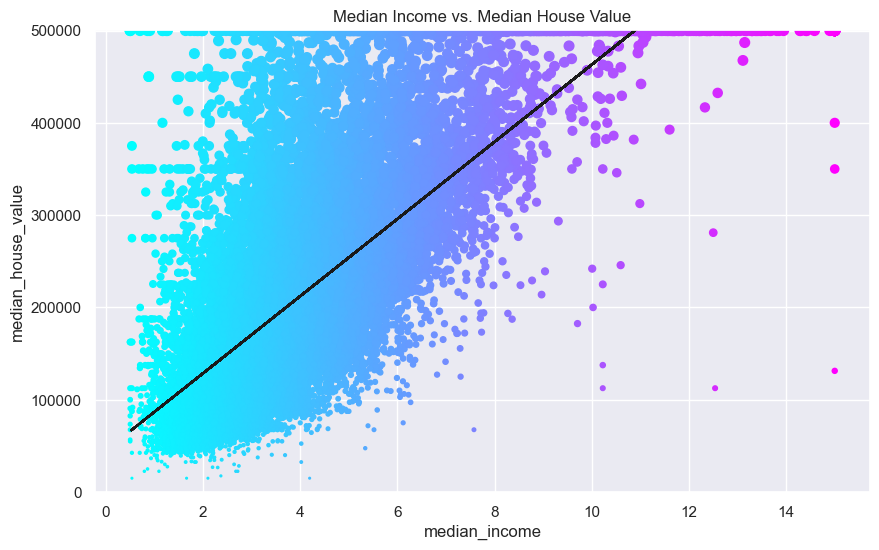

In [27]:
# plot correlation between income and home value
# scatter plot median_income and median_house_value with linear regression

# set variables for plotting
x=cal_features.median_income
y=cal_features.median_house_value

# create scatter plot
plt.subplots(figsize=(10,6))
plt.scatter(x=x, y=y, c=cal_features.median_income, cmap='cool', s=cal_features.median_house_value/10000)

# fit regression line and plot
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x), "k--")

# update plot labels
plt.title('Median Income vs. Median House Value')
plt.xlabel('median_income')
plt.ylabel('median_house_value')
plt.ylim(0,500500)
plt.show()

count    20640.000000
mean         3.870671
std          1.899822
min          0.499900
25%          2.563400
50%          3.534800
75%          4.743250
max         15.000100
Name: median_income, dtype: float64


<AxesSubplot:ylabel='Density'>

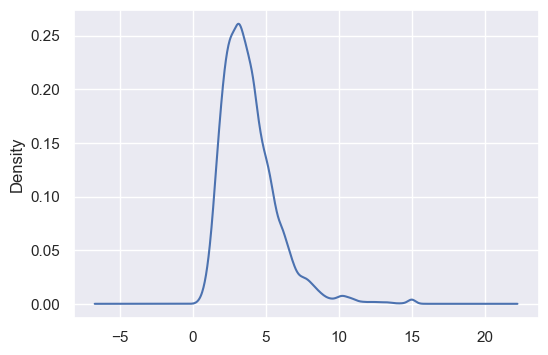

In [28]:
# median income distributions
print(cal_features.median_income.describe())
plt.subplots(figsize=(6,4))
cal_features.median_income.plot.density()

# Create new population features

In [29]:
# there are features that can be calculated from each block groups population and home size statistics
# we are going to calculate and add those here for testing with the model
# rooms_per_house, bedrooms_per_rooms, pop_per_house
cal_features['rooms_per_house'] = cal_features['total_rooms']/cal_features['households']
cal_features['bedrooms_per_rooms'] = cal_features['total_bedrooms']/cal_features['total_rooms']
cal_features['pop_per_house'] = cal_features['population']/cal_features['households']
cal_features.head()

,id,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value,miles_nearest_major_city,rooms_per_house,bedrooms_per_rooms,pop_per_house
0,1,41.0,880.0,129.0,322.0,126.0,8.3252,NEAR BAY,452600.0,12.64,6.984127,0.146591,2.555556
1,2,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,NEAR BAY,358500.0,12.39,6.238137,0.155797,2.109842
2,3,52.0,1467.0,190.0,496.0,177.0,7.2574,NEAR BAY,352100.0,11.10,8.288136,0.129516,2.802260
3,4,52.0,1274.0,235.0,558.0,219.0,5.6431,NEAR BAY,341300.0,10.62,5.817352,0.184458,2.547945
4,5,52.0,1627.0,280.0,565.0,259.0,3.8462,NEAR BAY,342200.0,10.62,6.281853,0.172096,2.181467


In [30]:
# check shape with new features
cal_features.shape

(20640, 13)

In [31]:
# interesting population statistics
print(f'      -----Cali Pop Averages-----\n'
    f'The mean population per block group: {round(cal_features.population.mean(), 2)}\n'
    f'The mean housholds per block group: {round(cal_features.households.mean(), 2)}\n'
    f'The mean housing_median_age per block group: {round(cal_features.housing_median_age.mean())}\n'
    f'The mean median_income per block group: {round(cal_features.median_income.mean(), 2)}\n'
    f'The mean median_house_value per block gorup: {round(cal_features.median_house_value.mean(), 2)}\n'
    f'The mean population per household: {round(cal_features.pop_per_house.mean(), 2)}\n'
    f'The mean rooms per household: {round(cal_features.rooms_per_house.mean(), 2)}\n'
    f'The mean bedrooms per room: {round(cal_features.bedrooms_per_rooms.mean(), 2)}\n'
)

      -----Cali Pop Averages-----
The mean population per block group: 1425.48
The mean housholds per block group: 499.54
The mean housing_median_age per block group: 29
The mean median_income per block group: 3.87
The mean median_house_value per block gorup: 206855.82
The mean population per household: 3.07
The mean rooms per household: 5.43
The mean bedrooms per room: 0.21



# Recreate Correlation Heatmap and Correlation Value Plot to Show Created Feature Value

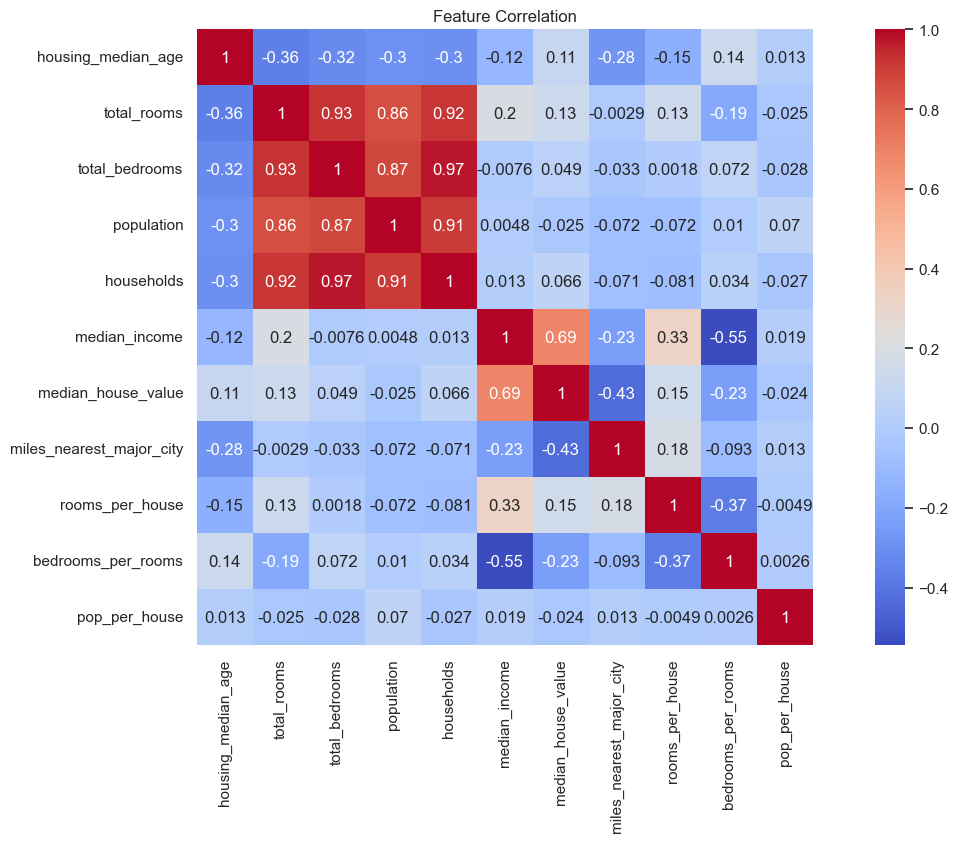

In [32]:
# recreate correlation heat map to check created features
# create correlation matrix
corr = cal_features.drop(columns='id').corr()

# create heatmap
sns.set(rc={'figure.figsize':(16,8)})
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True).set(title='Feature Correlation')
plt.show()

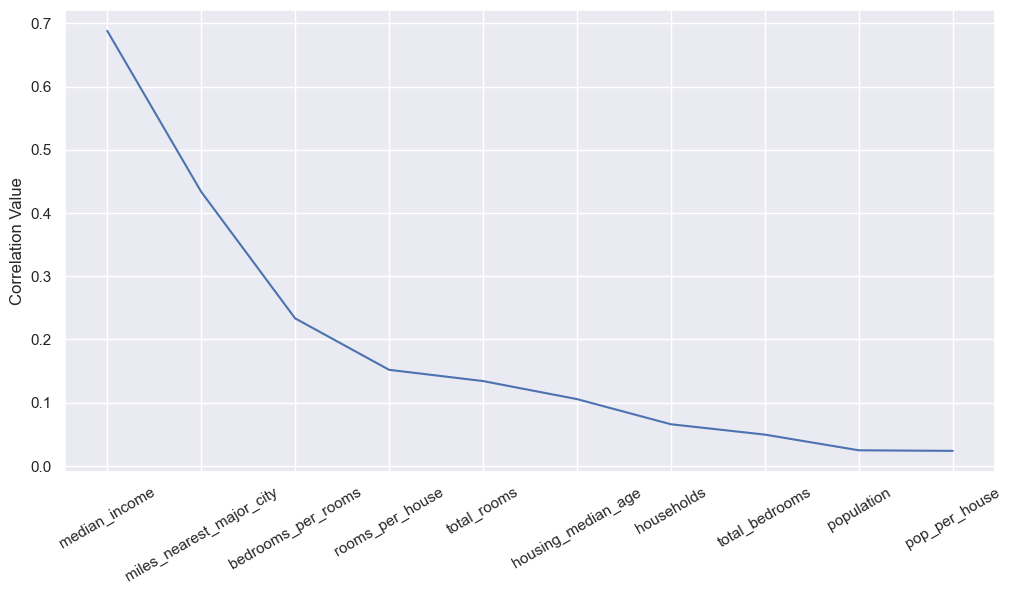

In [33]:
# plot target variables absolute correlation values in descending order
fig, ax = plt.subplots(figsize =(12, 6))
plt.plot(abs(corr)['median_house_value'].sort_values(ascending=False)[1:], label='Correlation to Median House Value')
plt.ylabel('Correlation Value')
plt.xticks(rotation=30)
plt.show()

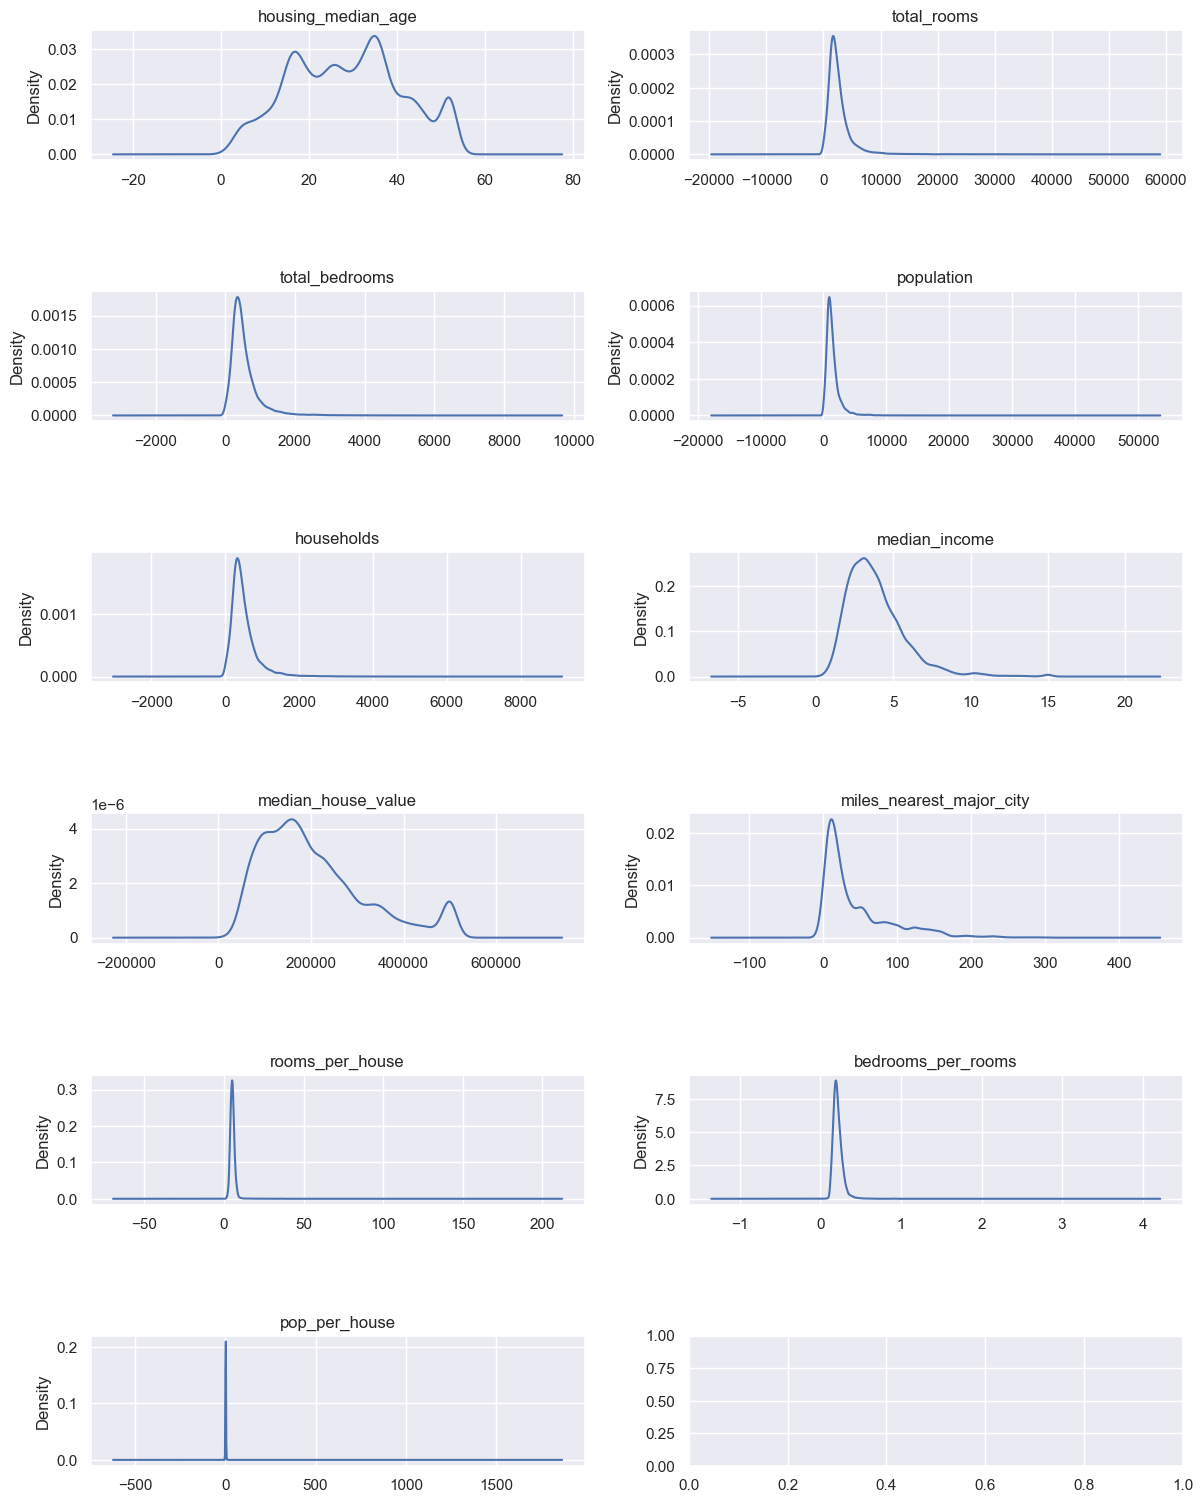

In [34]:
# plot distributions for numerical features
# select numerical columns
num_col = cal_features.select_dtypes(include='float64')
# create figure
fig, ax = plt.subplots(nrows=6,ncols=2, figsize=(12, 15))
index=0
ax = ax.flatten()
# add plot for each numerical feature to figure with ax[index]
for col in num_col:
    cal_features[col].plot.density(ax=ax[index])
    ax[index].set_title(col)
    index +=1
plt.tight_layout(pad = 0.5,w_pad =0.7 , h_pad =5)
plt.show()

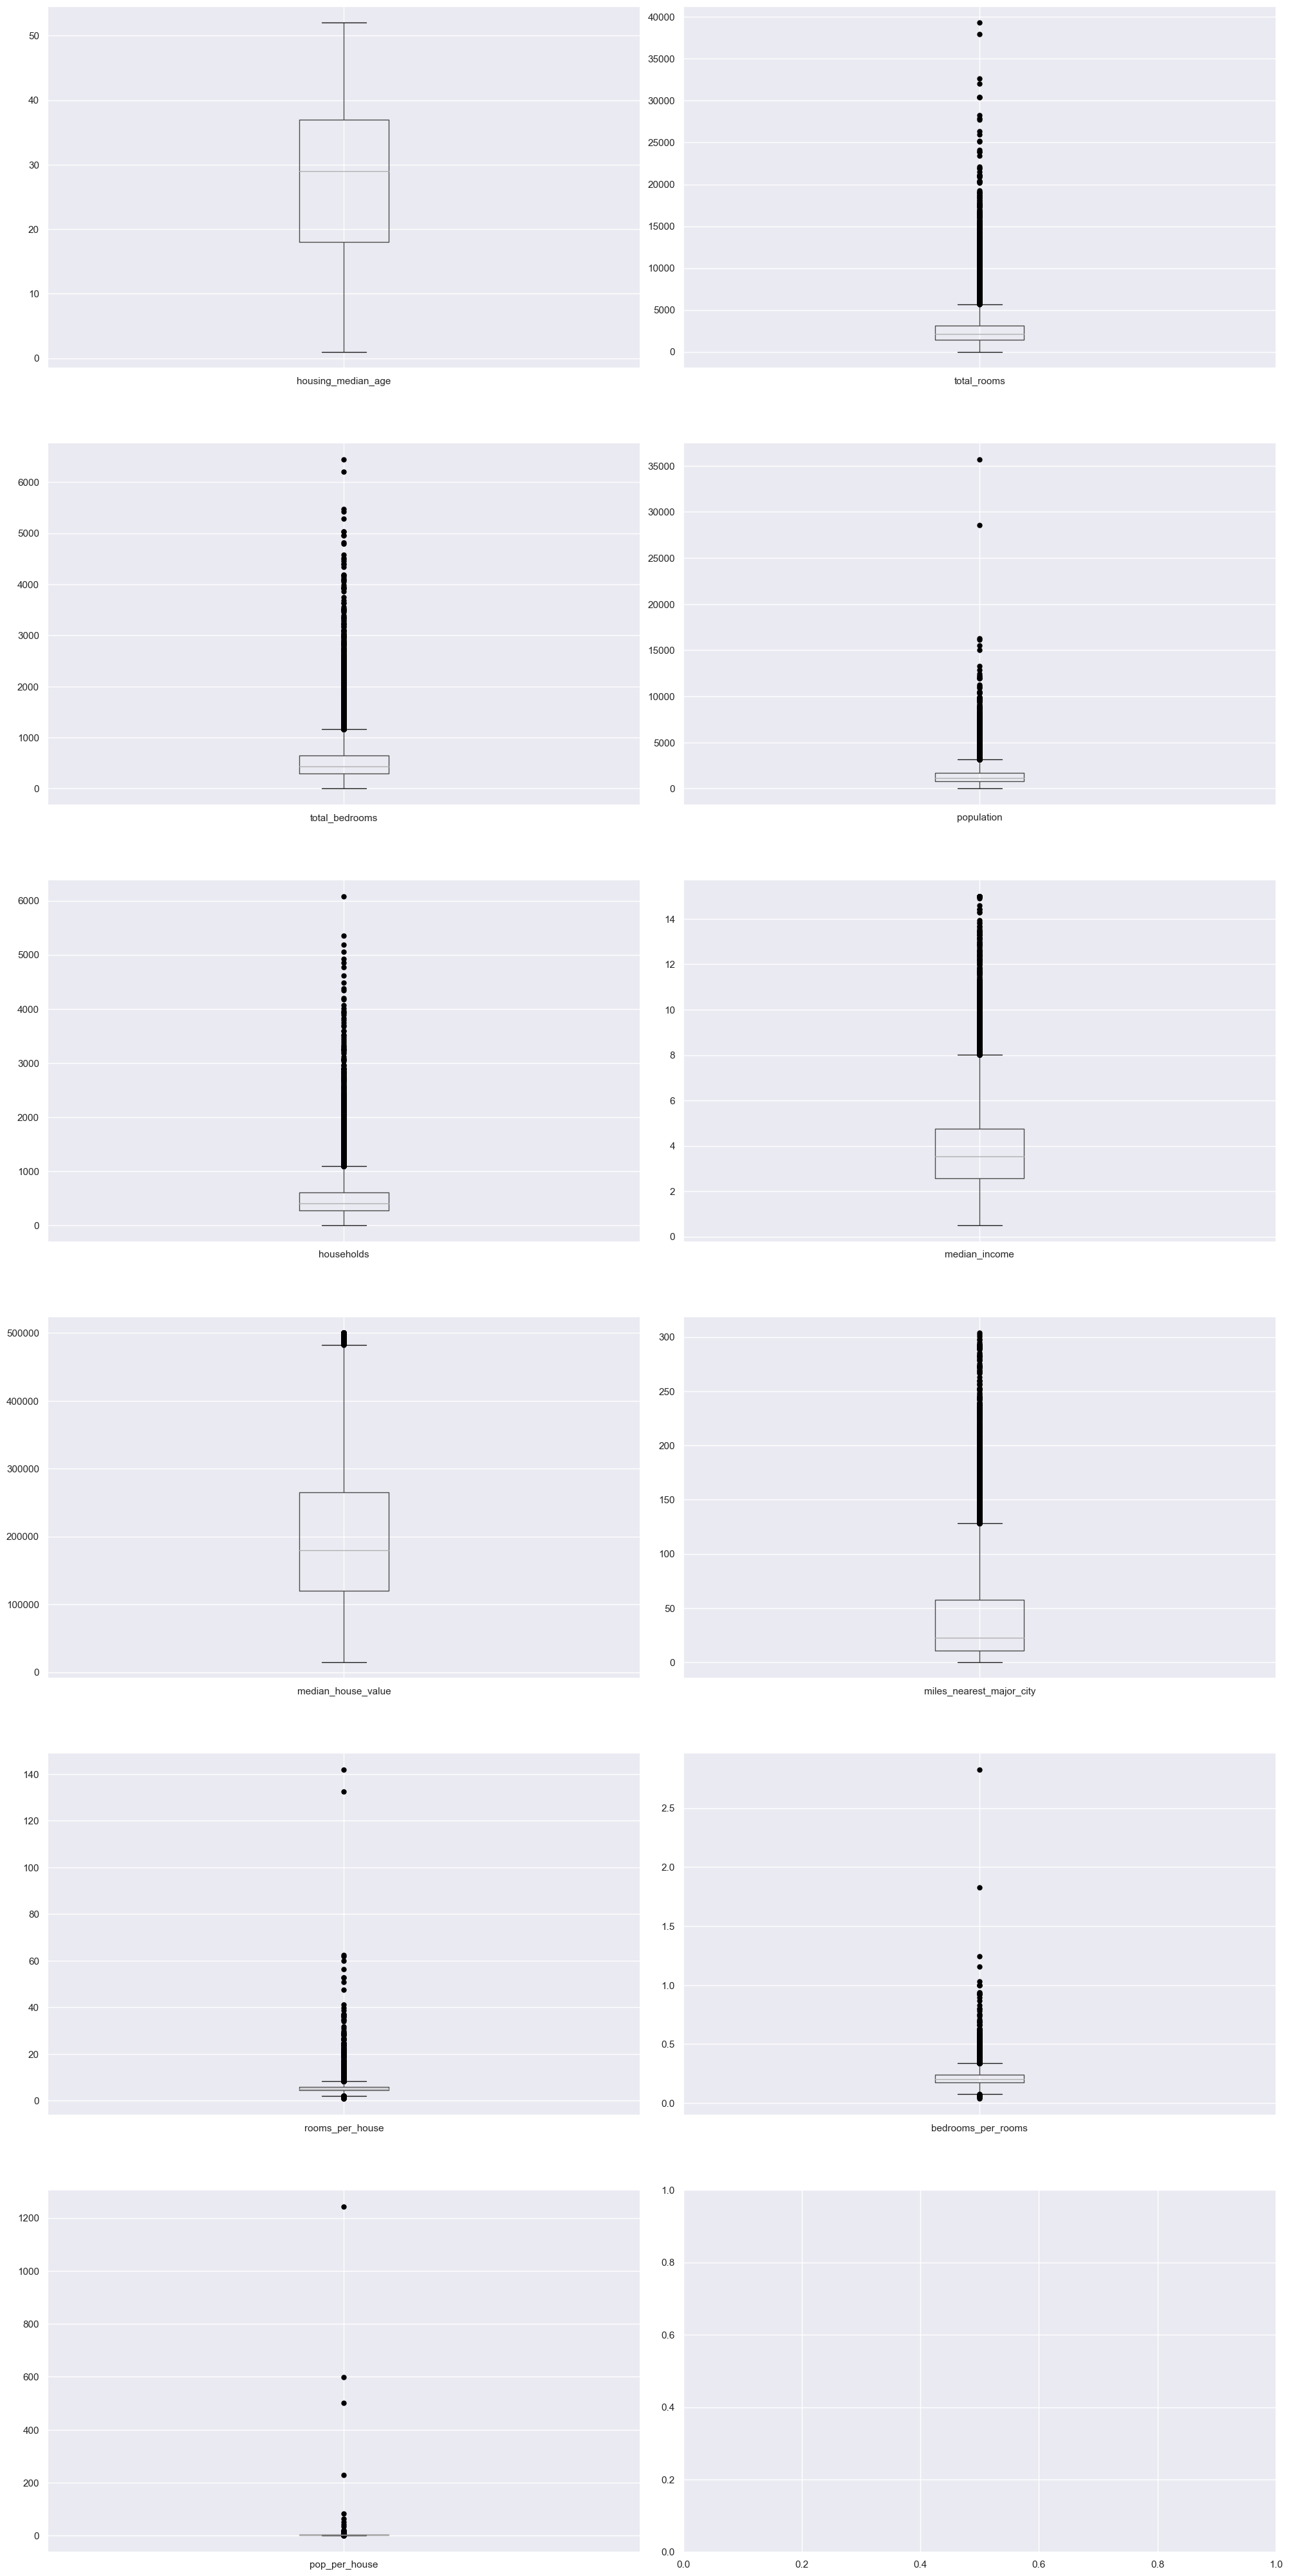

In [35]:
# boxplots for outlier detection on full dataset
# create box plot for each feature, check for outliers 

# set plot arrangement
rows = 6
cols = 2
# create figure
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize= (20,40))
index=0
ax = ax.flatten()
# loop through columns creating boxplots for each and adding to figure using ax index
for col in num_col:
    cal_features.boxplot(column=[col], ax=ax[index],flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'black'})
    index += 1

plt.tight_layout(pad = 0.5,w_pad =0.7 , h_pad =5)

In [36]:
cal_features.dtypes

id                            int64
housing_median_age          float64
total_rooms                 float64
total_bedrooms              float64
population                  float64
households                  float64
median_income               float64
ocean_proximity              object
median_house_value          float64
miles_nearest_major_city    float64
rooms_per_house             float64
bedrooms_per_rooms          float64
pop_per_house               float64
dtype: object

## Database Export:

In [37]:
# combine created features into created features table
created_features_df = cal_features[['id', 'bedrooms_per_rooms', 'rooms_per_house', 
                                    'pop_per_house', 'miles_nearest_major_city']]

print(created_features_df.dtypes)
created_features_df.head()


id                            int64
bedrooms_per_rooms          float64
rooms_per_house             float64
pop_per_house               float64
miles_nearest_major_city    float64
dtype: object


,id,bedrooms_per_rooms,rooms_per_house,pop_per_house,miles_nearest_major_city
0,1,0.146591,6.984127,2.555556,12.64
1,2,0.155797,6.238137,2.109842,12.39
2,3,0.129516,8.288136,2.802260,11.10
3,4,0.184458,5.817352,2.547945,10.62
4,5,0.172096,6.281853,2.181467,10.62


In [38]:
# create original features table from original dataframe
original_features_df = cal_df.drop(columns=['latitude', 'longitude'])

print(original_features_df.dtypes)
original_features_df.head()

housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
id                      int64
dtype: object


,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,1
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,2
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,3
3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,5


In [39]:
# add created features and original feature tables to database
# send tables to database using SQLAlchemy and pandas.to_sql()
created_features_df.to_sql('created_features', con=engine, index=False, if_exists='replace')
original_features_df.to_sql('original_features', con=engine, index=False, if_exists='replace')

# query database with pandas to test successful insertion.
print(engine.execute("SELECT * FROM original_features").fetchone())
print(engine.execute("SELECT * FROM created_features").fetchone())

(41.0, 880.0, 129.0, 322.0, 126.0, 8.3252, 452600.0, 'NEAR BAY', 1)
(1, 0.14659090909090908, 6.984126984126984, 2.5555555555555554, 12.64)
